In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

from tqdm import tqdm_notebook

In [2]:
from IPython.display import clear_output

In [3]:
print(nx.__version__)
print(np.__version__)

2.0
1.13.3


# Define functions

In [4]:
def generate_connections(n_nodes, con_p=0.5, min_length=10, max_length=50):
    """
    Create random connections in graph
    """
    connections = {}
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if np.random.rand()<con_p:
                v = np.random.randint(min_length, max_length+1)
                connections[(i,j)] = v
    return connections

In [5]:
def generate_matrix(connection_dict, n_nodes):
    """
    Create graph matrix based on given connections
    """
    A = np.ones((n_nodes,n_nodes)) * np.inf
    for i in range(n_nodes):
        A[i,i]=0
    for coord, val in connection_dict.items():
        A[coord]=val
        A[coord[::-1]] = val
    return A

In [6]:
def plot_graph(G, best_edges=None, title=None, colors=None):
    """
    G is a Graph from networkx library
    """
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=colors, width=1)
    labels = nx.get_edge_attributes(G,'weight')
    labels = {k:int(v) for k,v in labels.items()}
    if best_edges:
        best_edges_w = {e:int(A[e]) for e in best_edges}
        nx.draw(G, pos, with_labels=True, node_color=colors, edgelist=best_edges, width=3, edge_color='g')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=best_edges_w)
    else:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    if title: plt.title(title)
    plt.show()

In [7]:
def generate_path(path_len, start, stop, n_nodes):
    """
    Create random path. first and last elements are fixed 'start' and 'stop'
    """
    return np.hstack([start, np.random.randint(0, n_nodes, path_len-2), stop])

def get_path_len(path):
    return sum([A[a,b] for a,b in zip(path, path[1:])])

def get_fitness(chromo):
    """
    Main idea: the more path_lenth - the less fitness
    """
    return 1/get_path_len(chromo)

def select_pairs(paths):
    return np.array([(paths[i], paths[j]) for i,j in np.random.randint(0, len(paths), size=(N//2, 2))])

def crossover(a, b):
    return np.array([i if np.random.rand()<0.5 else j for i,j in zip(a,b)])

def mutation(chromos):
    mutated = np.array([i if np.random.rand()<1-MUTATION_P else np.random.randint(N_NODES) for i in chromos[1:-1]])
    return np.hstack([chromos[0], mutated, chromos[-1]])

def reduction(old_chromos, children, fits=None, is_manual=False):
    if is_manual:
        new_chromos = np.vstack([old_chromos[:1], children[:len(old_chromos)-1]])
    else:
        old_chromos_ids = list(range(len(old_chromos)))
        old_chromos_fits_ar = [(i, f) for i,f in zip(old_chromos_ids, fits)]
        old_chromos_ids = [i for i,f in sorted(old_chromos_fits_ar, key=lambda x: -x[1])]
        old_chromos = old_chromos[old_chromos_ids]
        new_chromos = np.vstack([old_chromos[:1],children[:len(old_chromos)-1]])
    return new_chromos

In [8]:
def select_manually(chromos):
    to_print = [(i, get_path_len(chromo), chromo,) for i,chromo in enumerate(chromos)]
    to_print = sorted(to_print, key = lambda line: line[1])
    ids_map = {line[0]:idx for idx, line in enumerate(to_print)}
    ids_map_r = {v:k for k,v in ids_map.items()}
    if CLEAR_OUTPUT: clear_output()
    print('Select best chromosomes')
    for line in to_print:
        print("{id_}: {l}, (len={length})".format(id_=ids_map[line[0]], l=line[2], length=line[1]))
    print('Enter best chromosomes ids:')
    ids = input().strip()
    if ids=='stop':
        raise StopIteration
    if len(ids)>0:
        ids = list(map(int, ids.split(' ')))
        ids = [ids_map_r[i] for i in ids]
        not_ids = [ids_map_r[i] for i in ids_map_r if i not in ids]
        parents = chromos[ids]
        chromos = np.vstack([chromos[ids], chromos[not_ids]])
    else:
        parents = chromos
    print('-----------------\n')
    return parents, chromos

In [9]:
def select_auto(chromos, fits):
    probs = np.exp(fits)/np.exp(fits).sum() #Softmax function
    parents = np.array([chromos[i] for i in np.random.choice(range(len(chromos)), p=probs, size=len(chromos))])
    return parents

In [10]:
def ga_step(mx, old_chromos, is_manual=False):
    chromos = old_chromos.copy()
    #if len(chromos)%2==1: raise Exception('chromos number should be odd')
    # step2: calculate fitness
    fits = np.array([get_fitness(chromo) for chromo in chromos])
    fits = fits/(fits.mean()+1e-10)
    # step3: select parents vectors
    if is_manual:
        parents, chromos = select_manually(chromos)
    else:
        parents = select_auto(chromos, fits)
    
    # step4: set pairs. apply crossover and mutation
    pairs = select_pairs(parents)
    children = np.array([crossover(pair[0],pair[1]) for pair in np.vstack([pairs,pairs])]) #Each pair gives 2 children
    mutated = np.array([mutation(child) for child in children])
    new_chromos = reduction(chromos, mutated, fits, is_manual)
    
    stats = np.array([old_chromos, parents, children, mutated, new_chromos])
    return new_chromos, stats

# Create graph

In [11]:
N_NODES = 10

In [12]:
connection_dict = generate_connections(N_NODES, con_p=0.5)

In [13]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

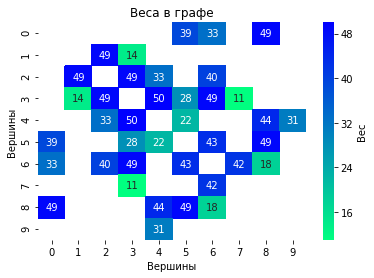

In [14]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [15]:
start_node, end_node = 0, 1

In [16]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

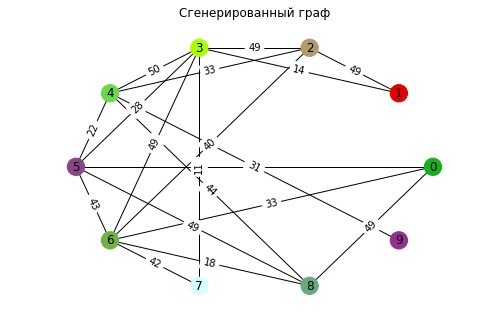

In [17]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

# Manual optimization

In [18]:
N=10
chromo_len = 10
is_manual = True
CLEAR_OUTPUT = False
MUTATION_P = 0.3

In [19]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [20]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

Select best chromosomes
0: [0 5 3 6 6 2 6 3 1 1], (len=259.0)
1: [0 6 9 7 0 7 3 7 2 1], (len=inf)
2: [0 9 6 4 2 7 7 0 0 1], (len=inf)
3: [0 4 5 8 1 7 9 9 7 1], (len=inf)
4: [0 9 3 7 3 7 4 1 5 1], (len=inf)
5: [0 5 2 5 2 9 4 4 9 1], (len=inf)
6: [0 7 4 0 7 8 6 8 1 1], (len=inf)
7: [0 9 1 0 7 6 7 8 7 1], (len=inf)
8: [0 0 4 4 3 3 1 4 2 1], (len=inf)
9: [0 0 0 6 3 0 0 1 0 1], (len=inf)
Enter best chromosomes ids:
0 5
-----------------

Select best chromosomes
0: [0 5 3 6 6 2 6 3 1 1], (len=259.0)
1: [0 5 4 2 2 2 9 4 9 1], (len=inf)
2: [0 7 2 5 2 9 4 4 9 1], (len=inf)
3: [0 5 2 6 2 9 4 4 9 1], (len=inf)
4: [0 5 2 0 2 1 3 4 9 1], (len=inf)
5: [0 5 2 6 2 8 6 4 2 1], (len=inf)
6: [0 5 2 6 2 1 6 8 5 1], (len=inf)
7: [0 4 2 5 2 9 4 4 9 1], (len=inf)
8: [0 5 5 5 7 2 6 2 1 1], (len=inf)
9: [0 5 2 5 2 9 4 4 9 1], (len=inf)
Enter best chromosomes ids:
0 8
-----------------

Select best chromosomes
0: [0 8 6 6 6 7 6 3 1 1], (len=214.0)
1: [0 5 3 6 6 2 2 3 1 1], (len=219.0)
2: [0 5 3 6 6 2 1 3 1 1], 

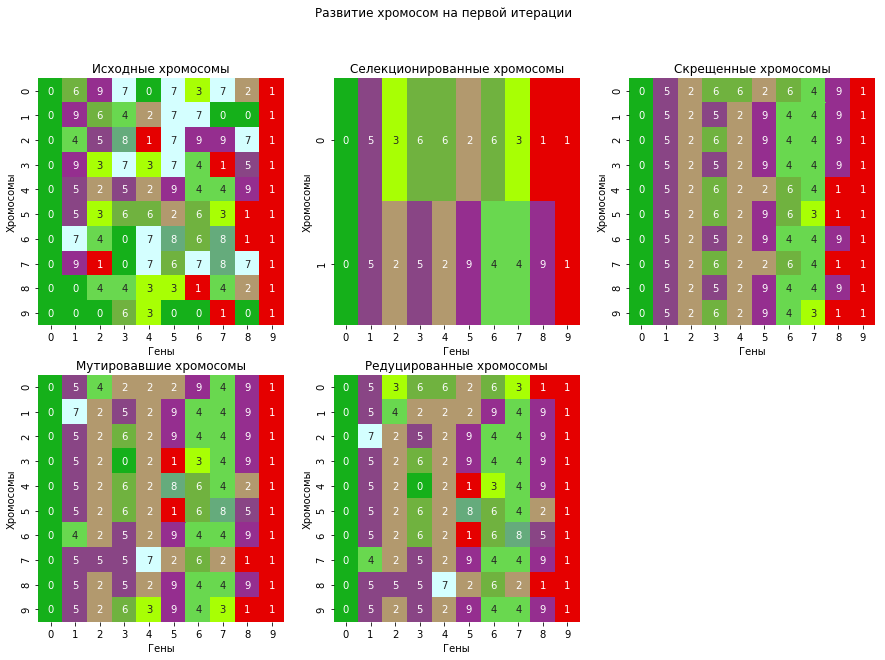

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(231)
sns.heatmap(stats[0][0], cmap=colors, cbar=False, annot=True)
plt.ylabel('Хромосомы')
plt.xlabel('Гены')
plt.title('Исходные хромосомы')

plt.subplot(232)
sns.heatmap(stats[0][1], cmap=colors, cbar=False, annot=True)
plt.ylabel('Хромосомы')
plt.xlabel('Гены')
plt.title('Селекционированные хромосомы')

plt.subplot(233)
sns.heatmap(stats[0][2], cmap=colors, cbar=False, annot=True)
plt.ylabel('Хромосомы')
plt.xlabel('Гены')
plt.title('Скрещенные хромосомы')

plt.subplot(234)
sns.heatmap(stats[0][3], cmap=colors, cbar=False, annot=True)
plt.ylabel('Хромосомы')
plt.xlabel('Гены')
plt.title('Мутировавшие хромосомы')

plt.subplot(235)
sns.heatmap(stats[0][4], cmap=colors, cbar=False, annot=True)
plt.ylabel('Хромосомы')
plt.xlabel('Гены')
plt.title('Редуцированные хромосомы')
plt.suptitle('Развитие хромосом на первой итерации')
plt.show()

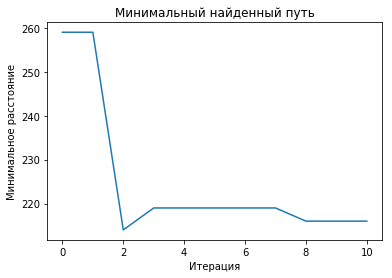

In [22]:
plot_data = np.array(min_path_lens)
#plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers
plot_data[np.isinf(plot_data)]=3#plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

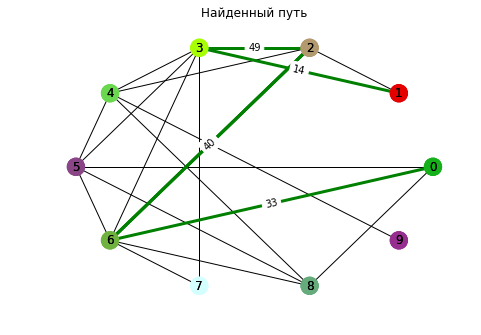

In [23]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Automatic optimization

In [26]:
N=1000
path_len = 10
early_stopping_steps = 100
is_manual = False
MUTATION_P = 0.3

In [27]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [28]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

C:\Users\egord\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\egord\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\egord\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until



early stops at 104
result 81.0


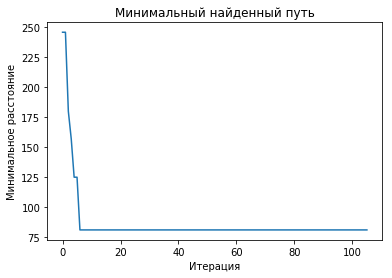

In [32]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

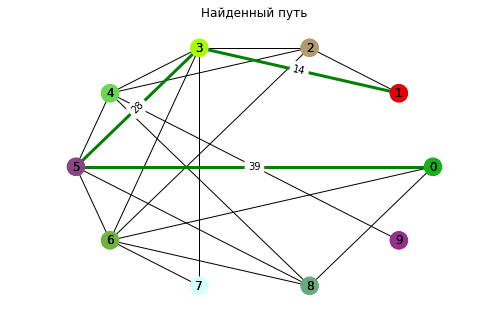

In [33]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 3

In [127]:
connection_dict = generate_connections(N_NODES, con_p=0.6)

In [128]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

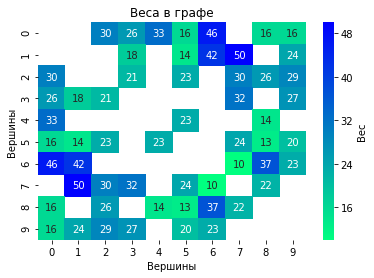

In [129]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [130]:
start_node, end_node = 0, 1

In [131]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

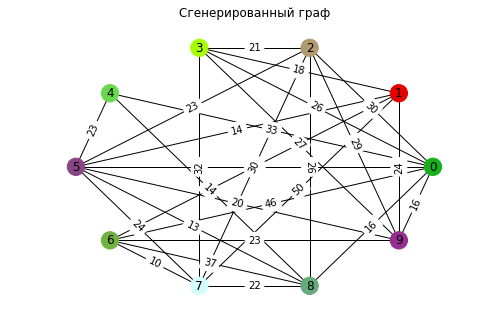

In [132]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [133]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [134]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 138
result 30.0



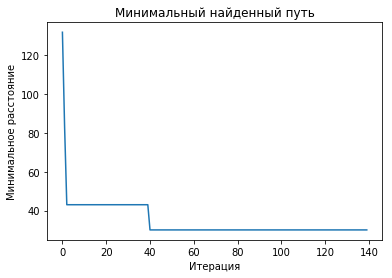

In [135]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

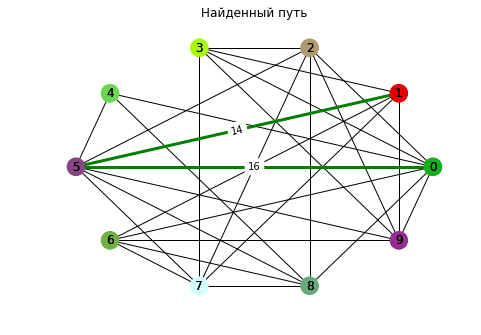

In [136]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 4

In [137]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

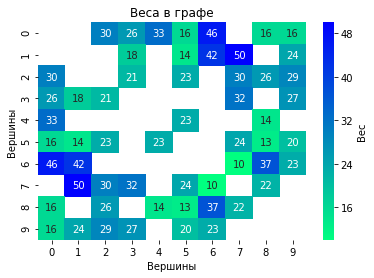

In [138]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [139]:
start_node, end_node = 0, 6

In [140]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

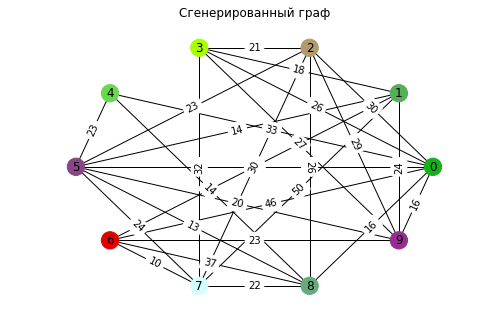

In [141]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [142]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [143]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 103
result 48.0



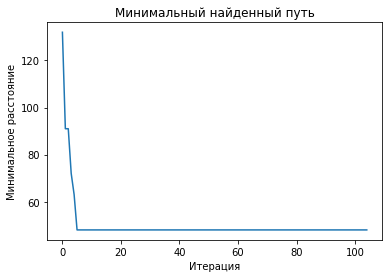

In [144]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

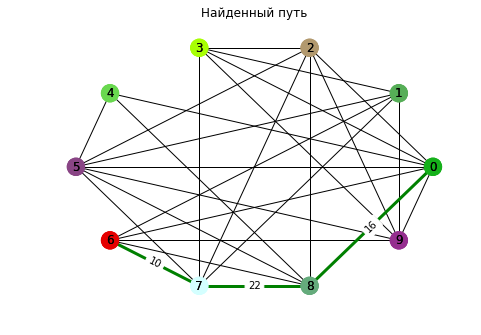

In [145]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 5

In [146]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

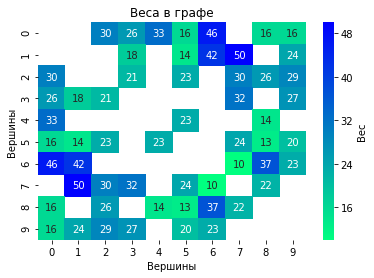

In [147]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [148]:
start_node, end_node = 1,9 

In [149]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

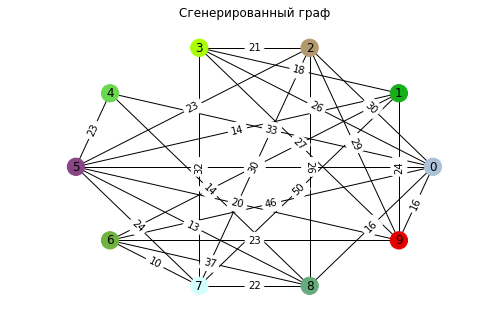

In [150]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [151]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [152]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 110
result 24.0



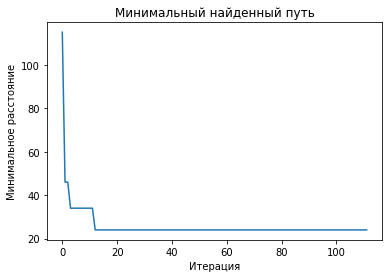

In [153]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

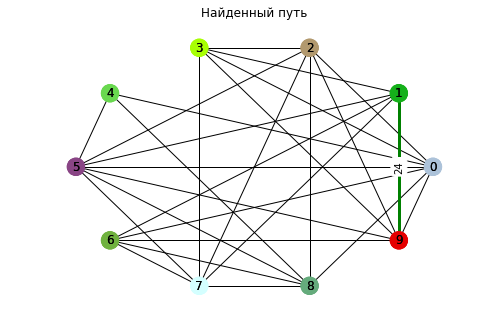

In [154]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 6

In [155]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

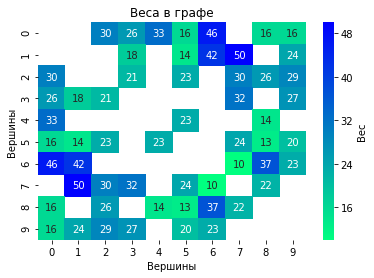

In [156]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [157]:
start_node, end_node = 2, 7

In [158]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

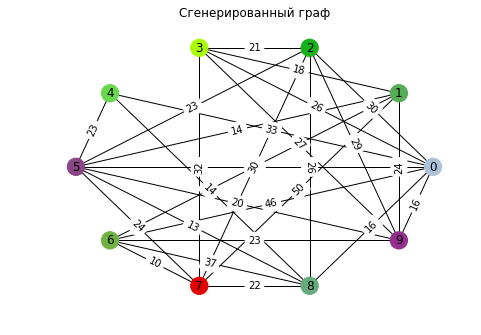

In [159]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [160]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [161]:
for i in tqdm_notebook(range(150)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 101
result 47.0



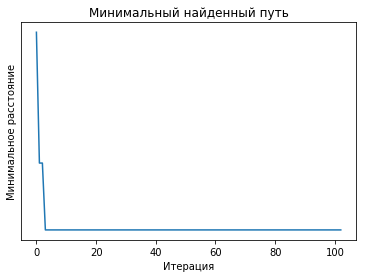

In [162]:
plot_data = np.array(min_path_lens)
#plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers
plot_data[np.isinf(plot_data)]=1

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
plt.yticks([1],['inf'])
#plt.yscale('log')
plt.show()

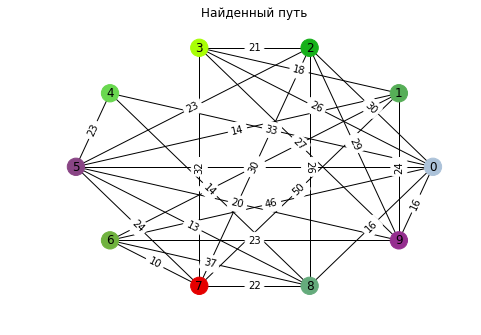

In [163]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
#best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, title='Найденный путь', colors=colors)

# Эксперимент 7

In [164]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

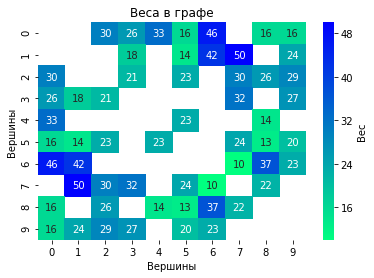

In [165]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [166]:
start_node, end_node = 1,6

In [167]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

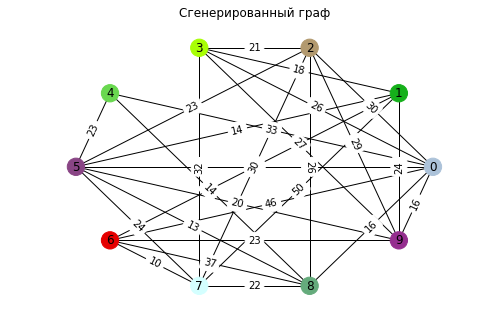

In [168]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [169]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [170]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 103
result 48.0



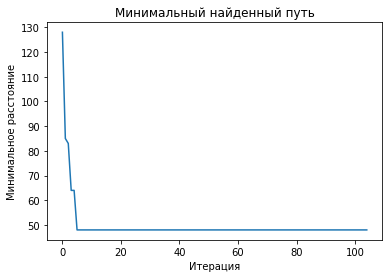

In [171]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

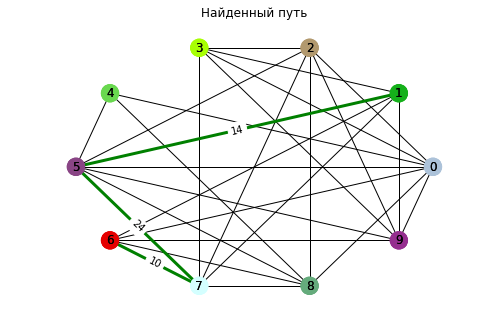

In [172]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 8

In [173]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

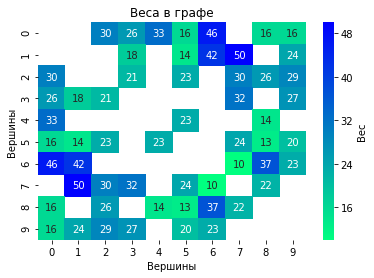

In [174]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [175]:
start_node, end_node = 4, 6

In [176]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

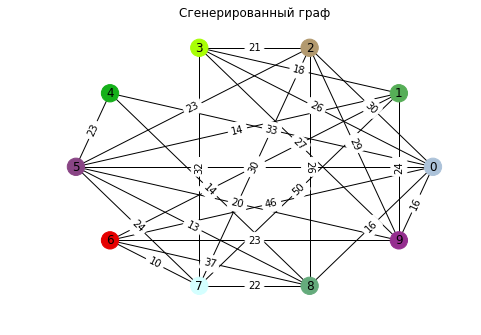

In [177]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [178]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [179]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 117
result 46.0



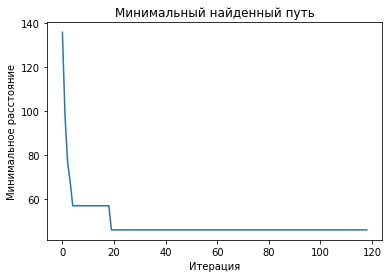

In [180]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

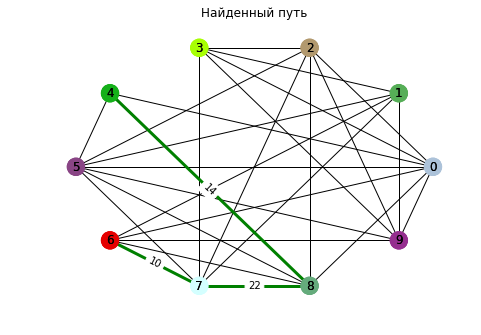

In [181]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 9

In [182]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

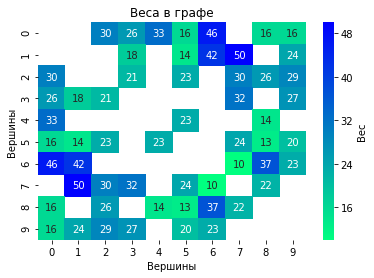

In [183]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [184]:
start_node, end_node = 8,9

In [185]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

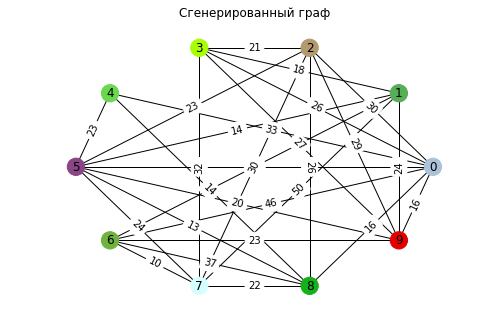

In [186]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [187]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [188]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

early stops at 103
result 32.0



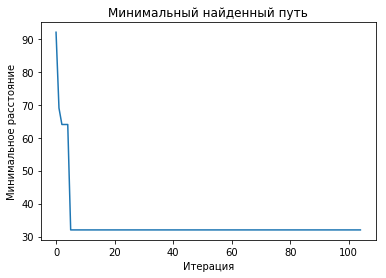

In [189]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=plot_data[~np.isinf(plot_data)].max()*1.2 #Replace inf with finite numbers

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
#plt.yscale('log')
plt.show()

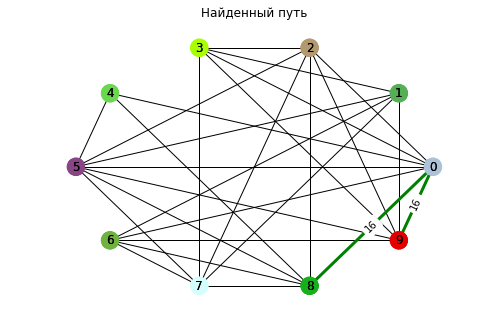

In [190]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)

# Эксперимент 10

In [191]:
connection_dict = generate_connections(N_NODES, con_p=0.2)

In [192]:
A = generate_matrix(connection_dict, N_NODES) # Матрица графа
G = nx.Graph(A) # Граф для рисования
edges_to_remove = [ (i,j) for i in range(N_NODES) for j in range(N_NODES) if np.isinf(A[i,j])]
G.remove_edges_from(edges_to_remove)

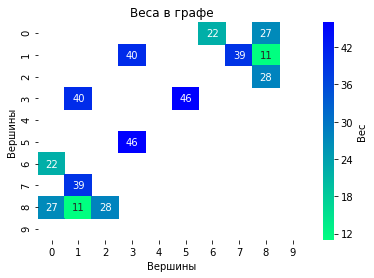

In [193]:
A_to_print = A.copy()
A_to_print[A_to_print==0] = None
A_to_print[A_to_print==np.inf] = None

sns.heatmap(A_to_print, cmap='winter_r', annot=True, cbar_kws={'label':'Вес'})
plt.title('Веса в графе')
plt.xlabel('Вершины')
plt.ylabel('Вершины')
plt.show()

In [197]:
start_node, end_node = 0, 4

In [198]:
colors = list(mcolors.get_named_colors_mapping().keys())[:N_NODES]
colors = ['xkcd:green' if i==start_node else 'xkcd:red' if i==end_node else colors[i] for i in range(len(colors))]

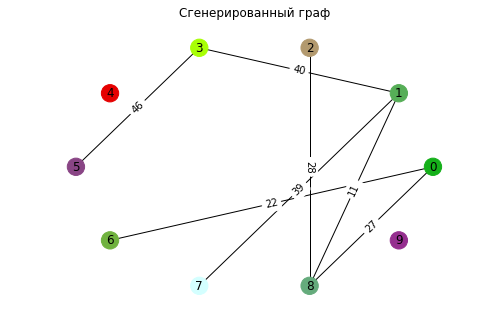

In [199]:
plot_graph(G, title='Сгенерированный граф', colors=colors)

In [200]:
chromos = np.array([generate_path(chromo_len, start_node, end_node, N_NODES) for i in range(N)])
all_chromos = np.array([chromos])
min_path_lens = np.array([min([get_path_len(i) for i in chromos])])
stats = []

In [201]:
for i in tqdm_notebook(range(1000)):
    try:
        chromos, stat = ga_step(A, chromos, is_manual=is_manual)
    except StopIteration:
        print("Stopped at",i)
        break
    stats.append(stat)
    
    min_path_lens = np.append(min_path_lens, min([get_path_len(i) for i in chromos]))
    all_chromos = np.append(all_chromos, [chromos], axis=0)
    
    min_len = min_path_lens[-1]
    if not is_manual and i>=early_stopping_steps \
        and min_len!=np.inf and all(min_len==min_path_lens[- early_stopping_steps:]):
        print('early stops at',i)
        print('result', min_len)
        break
stats = np.array(stats)

A Jupyter Widget

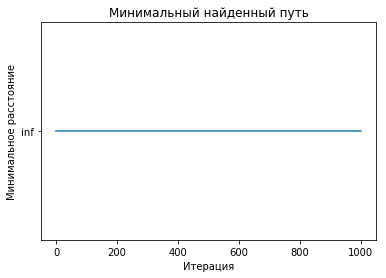

In [203]:
plot_data = np.array(min_path_lens)
plot_data[np.isinf(plot_data)]=1

plt.plot(plot_data)
plt.title('Минимальный найденный путь')
plt.ylabel('Минимальное расстояние')
plt.xlabel('Итерация')
plt.yticks([1],['inf'])
#plt.yscale('log')
plt.show()

In [ ]:
best_chromo = chromos[np.argmin([get_path_len(i) for i in chromos])]
best_chromo = best_chromo[np.append(best_chromo[:-1]!=best_chromo[1:], True)]
best_edges = [(best_chromo[i], best_chromo[i+1]) for i in range(len(best_chromo[:-1]))]

plot_graph(G, best_edges=best_edges, title='Найденный путь', colors=colors)